In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_val_path = "./heart_failure/train_val_split.csv"
df = pd.read_csv(train_val_path)
print(df.shape)

df

(734, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [17]:
### THERE ARE NO MISSING VALUES!!!
missing_values_count = df.isna().sum()
print(missing_values_count)

#See vars
print(df.dtypes)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


In [18]:
### Wait, some variables are not numeric... let's encode them!

#Find object variables (pandas don't know what they are)
object_columns = df.select_dtypes(include=['object']).columns.tolist()
print(object_columns)

#Let's make them categoric
df2=df.copy()
df2[object_columns] = df2[object_columns].apply(lambda x: x.astype("category")) 

# Iterate over each column
for col in df2.columns:
    # Check if the column is categorical
    if isinstance(df2[col].dtype, pd.CategoricalDtype):
        # Print the column name and its unique values
        print(f"Unique values of {col}: {df2[col].unique()}")

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Unique values of Sex: ['M', 'F']
Categories (2, object): ['F', 'M']
Unique values of ChestPainType: ['ATA', 'ASY', 'NAP', 'TA']
Categories (4, object): ['ASY', 'ATA', 'NAP', 'TA']
Unique values of RestingECG: ['Normal', 'ST', 'LVH']
Categories (3, object): ['LVH', 'Normal', 'ST']
Unique values of ExerciseAngina: ['N', 'Y']
Categories (2, object): ['N', 'Y']
Unique values of ST_Slope: ['Up', 'Flat', 'Down']
Categories (3, object): ['Down', 'Flat', 'Up']


In [19]:
#Let's make sex and ExerciseAngina binary variables
df3=df2.copy()
df3["Female"]=(df3["Sex"]=="F")
df3.drop(columns='Sex', inplace=True)

df3["ExerciseAngina"]=(df2["ExerciseAngina"]=="Y")

#Since there is no inherent order between chestpaintypes, and between RestingECG alterations, 
#let's dummy encode them, using the omitted value as the normal/assymptomatic
df3 = pd.get_dummies(df3, columns=["ChestPainType", "RestingECG", "ST_Slope"], prefix=["ChestPainType is ", "RestingECG is ", "ST_Slope is "])

df3.drop(columns=["ChestPainType is _ASY", "RestingECG is _Normal", "ST_Slope is _Flat"], inplace=True)

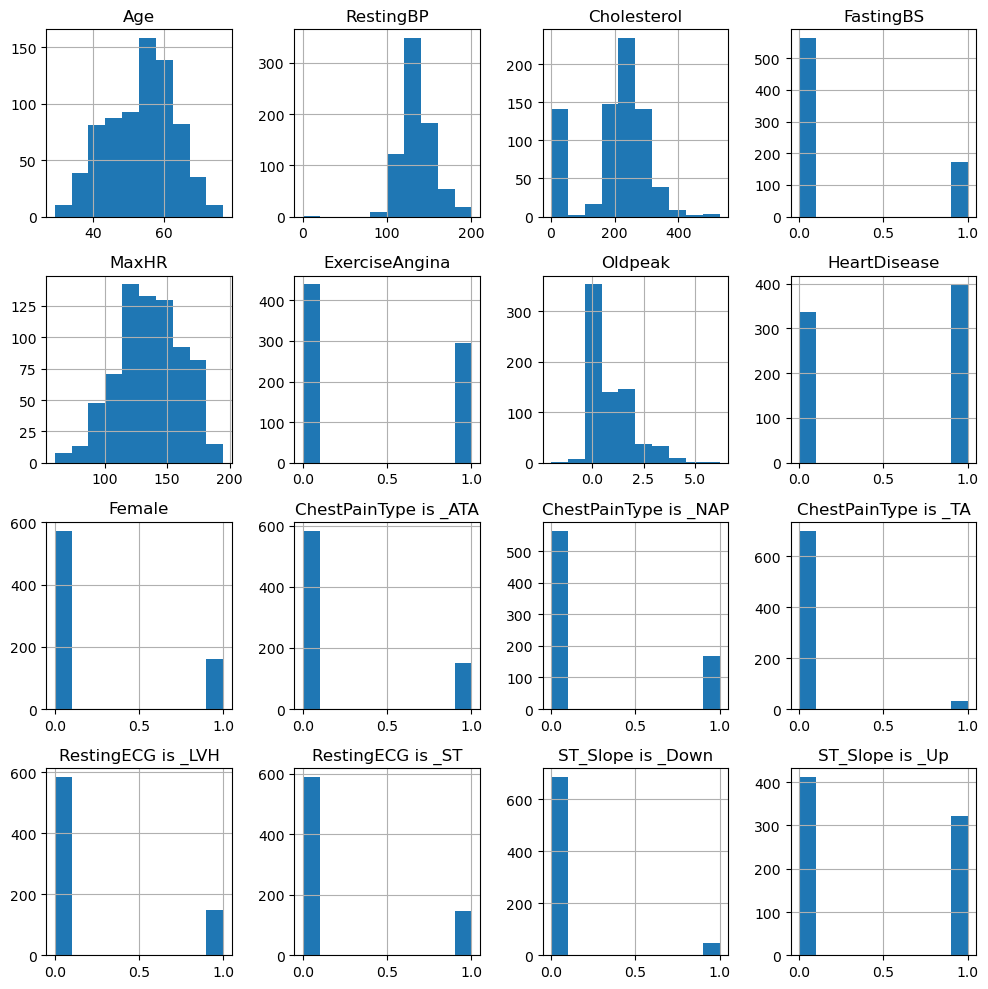

In [20]:
#To apply regression (and see histograms) we should treat everything as numeric

# PLOT HISTOGRAM AFTER ENCODING OF VARIABLES
df4=df3.astype("float64")
df4.hist(figsize=(10, 10))  # Adjust figsize as needed
plt.tight_layout()  # Adjust layout
plt.show()

We can see that age is fairly distributed, center at 50-55. Same for MaxHR.
Most patients have normal ECG, no chest pain, are males.
Most have normal fasting Blood Sugar, 
classes are almost evenly distributed (40%-60%).

But let's look at outliers:

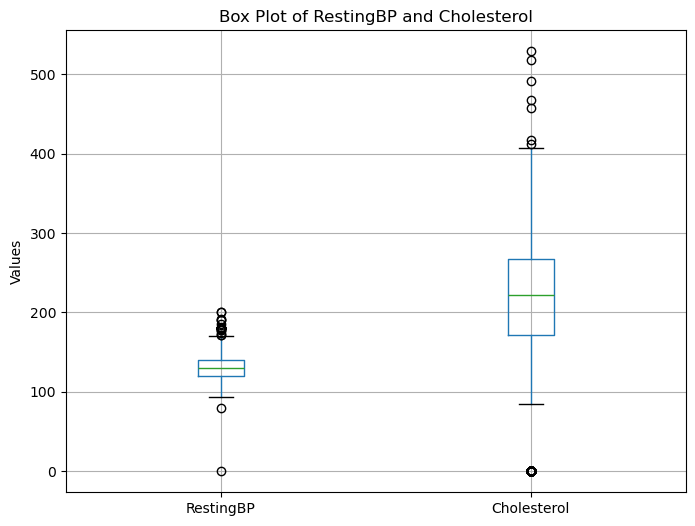

In [21]:
###Colesterol and Resting BP look sus, let's see them closer
# Create a box plot of them
plt.figure(figsize=(8, 6))
df4[["RestingBP", "Cholesterol"]].boxplot()
plt.title('Box Plot of RestingBP and Cholesterol')
plt.ylabel('Values')
plt.grid(True)
plt.show()

Well, RestingBP and Cholesterol cannot be zero. I'll assume that they weren´t measured. 
So I'll input these zeros with the median of the data.

In [22]:
df4['RestingBP_missing'] = df4['RestingBP'].apply(lambda x: 1 if x == 0 else 0)
df4['Cholesterol_missing'] = df4['Cholesterol'].apply(lambda x: 1 if x == 0 else 0)

Let's save to use for the models.

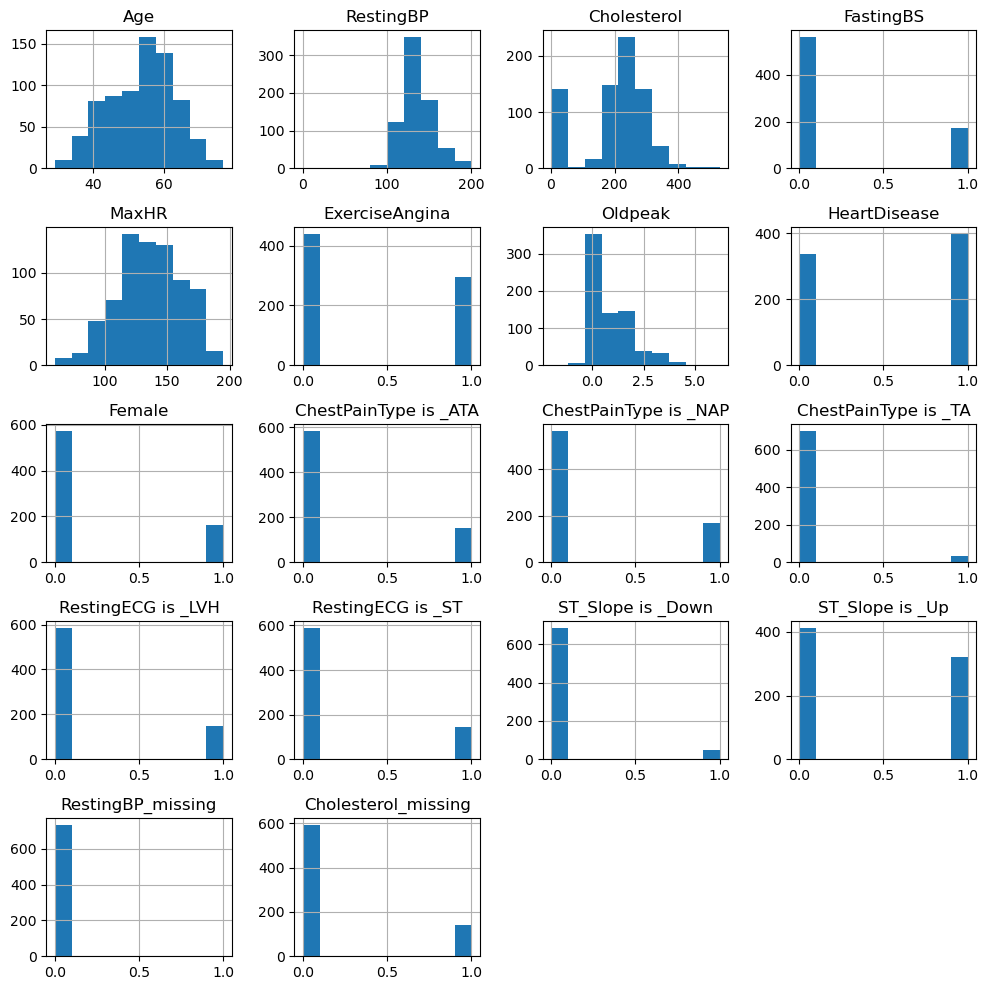

In [24]:
# PLOT HISTOGRAM
df4.hist(figsize=(10, 10))  # Adjust figsize as needed
plt.tight_layout()  # Adjust layout
plt.show()

RestingBP is missing only in one sample, that is why it looks like there are no cases when RestingBP_missing = 1

In [25]:
test_path = "./heart_failure/test_split.csv"
df_test = pd.read_csv(test_path)
object_columns = df_test.select_dtypes(include=['object']).columns.tolist()
df_test[object_columns] = df_test[object_columns].apply(lambda x: x.astype("category"))
df_test["Female"]=(df_test["Sex"]=="F")
df_test.drop(columns='Sex', inplace=True)

df_test["ExerciseAngina"]=(df_test["ExerciseAngina"]=="Y")

#Since there is no inherent order between chestpaintypes, and between RestingECG alterations, 
#let's dummy encode them, using the omitted value as the normal/assymptomatic
df_test = pd.get_dummies(df_test, columns=["ChestPainType", "RestingECG", "ST_Slope"], prefix=["ChestPainType is ", "RestingECG is ", "ST_Slope is "])

df_test.drop(columns=["ChestPainType is _ASY", "RestingECG is _Normal", "ST_Slope is _Flat"], inplace=True) 

df_test=df_test.astype("float64")

df_test['RestingBP_missing'] = df_test['RestingBP'].apply(lambda x: 1 if x == 0 else 0)
df_test['Cholesterol_missing'] = df_test['Cholesterol'].apply(lambda x: 1 if x == 0 else 0)

In [26]:
df4["HeartDisease"]=df4["HeartDisease"].astype(int)
df_test["HeartDisease"]=df_test["HeartDisease"].astype(int)

df4.to_csv('preprocessed_heart_train_val_missingness.csv', index=False)
df_test.to_csv('preprocessed_heart_test_missingness.csv', index=False)